# Plateau comparison
*Feb 25 2020*

In this notebook, we'll measure the strength of the plateau in the power spectrum, as a function of subhalo density and redshift. We'll use a Sheth-Tormen mass function for the interlopers when that's ready.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u

from scipy.integrate import quad, dblquad
from scipy.interpolate import interp2d

from helpers import sigma_cr

In [37]:
from scipy.interpolate import interp1d

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.316)

## Subhalos
$$P(k = 0) = \frac{1}{\Sigma_{cr}^2}\int_{10^5}^{10^8} dm \, m^2 \frac{d^2N}{dmdA}(z_l,m)$$
where
$$\frac{d^2 N}{dmdA}(z_l, m) = \frac{\Sigma_{sub}^{new}}{m_0}\left(\frac{m}{m_0}\right)^{-1.9}\sqrt{1+z_l}$$
and $\Sigma_{sub}^{new} = \Sigma_{sub}^{old}/\sqrt{1+z_{old}}$.

In [3]:
m0 = 1e8 #* u.Msun
sigma_old_ana = 0.125 #/ u.kpc**2
sigma_new_ana = sigma_old_ana / np.sqrt(1+0.5) # since their main lens had $z=0.5$
print(sigma_new_ana)

0.10206207261596577


In [4]:
sigma_cr(.5,1)

<Quantity 3.11654993e+15 solMass / Mpc2>

In [5]:
def power_sub(z_l, z_s, mlow=1e5, mhigh=1e8):
    sigcr = sigma_cr(z_l, z_s).to(u.M_sun/u.kpc**2).value
    #sigcr = 1
    def massfunc(m):
        return sigma_new_ana / m0 * (m/m0)**-1.9 * np.sqrt(1+z_l)
    
    #print('massfunc', massfunc(1e7))
    integral = quad(lambda m: m**2 * massfunc(m), mlow, mhigh)[0]
    #print('integral error', integral[1]/integral[0])
    return 1/sigcr**2 * integral
    
power_sub(.5,1)

0.0001169368610999234

In [77]:
# Calculate subhalo power (plateau) grid
zllist = np.linspace(0,3,100)
zslist = np.linspace(0,3,100)
sub_power_grid = np.zeros((len(zllist), len(zslist)))
for i_l, z_l in enumerate(zllist):
    for i_s, z_s in enumerate(zslist):
        if z_s <= z_l: continue
        
        sub_power_grid[i_l, i_s] = power_sub(z_l, z_s)

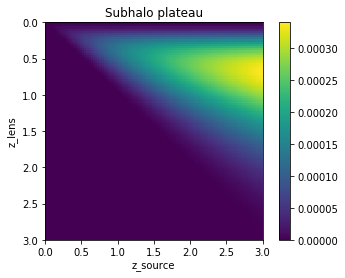

In [85]:
plt.imshow(sub_power_grid, extent=[0,3,3,0])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Subhalo plateau')
#plt.savefig('imgs/feb25_subplat.png')

In [89]:
power_sub(.5,1)

0.0001169368610999234

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Subhalo plateau (log scale)')

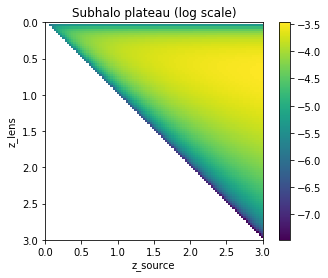

In [65]:
plt.imshow(np.log10(sub_power_grid), extent=[0,3,3,0])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Subhalo plateau (log scale)')

In [66]:
#plt.contour(sub_power_grid, origin='upper', extent=[0,3,3,0])

In [67]:
power_sub(.5,1)

0.0001169368610999234

## Interlopers
$$P_0  \approx \frac{1}{\Sigma_{cr}^2} \int_0^{z_s} dz \frac{d\chi}{dz} \frac{R^2(z)}{R^2(z_l)} \int_{10^5}^{10^8} m^2 n(z, m) dm$$
or putting the integral directly in terms of the comoving distance,
$$P_0  \approx \frac{1}{\Sigma_{cr}^2} \int_0^{\chi_s} d\chi \frac{R^2(\chi)}{R^2(\chi_l)} \int_{10^5}^{10^8} m^2 n(z(\chi), m) dm$$
where the approximation is due to the fact that we're not accounting for effective mass. Since Hongming asked, we should also try putting the $\Sigma_{cr}^2$ inside the integral (using $z_d = z$ of course) and see how much that affects results.

### Sheth-Tormen mass function

In [11]:
# Load ST results
h = .675
massesn = np.load('files/st_results/0_massesn_ST.npy')
massfunc_mat = np.load('files/st_results/0_massfunc_ST.npy') * h**3/1000**3
redshifts = np.load('files/st_results/0_redshifts_ST.npy')

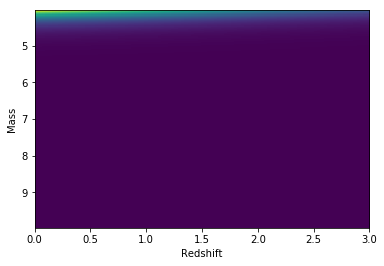

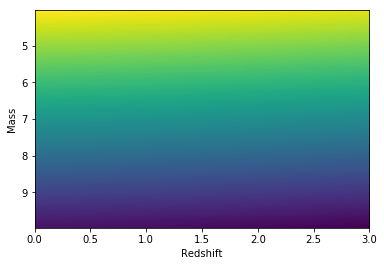

In [12]:
plt.imshow(massfunc_mat, extent=[redshifts[0], redshifts[-1], np.log10(massesn[-1]), np.log10(massesn[0])], aspect='auto')
plt.xlabel('Redshift')
plt.ylabel('Mass')
plt.show()
plt.imshow(np.log(massfunc_mat), extent=[redshifts[0], redshifts[-1], np.log10(massesn[-1]), np.log10(massesn[0])], aspect='auto')
plt.xlabel('Redshift')
plt.ylabel('Mass')
plt.show()

In [27]:
massfunc = interp2d(redshifts, massesn, massfunc_mat, bounds_error=False) # function of (z, mass)

### Double-cone radius

In [14]:
def double_cone_direct(com_z, com_l, com_s):
    # Input can be in any units
    if com_z < com_l:
        return com_z / com_l
    else:
        return (com_s - com_z) / (com_s - com_l)

## Mass integral

In [31]:
def chi_to_z(chi):
    return z_at_value(cosmo.comoving_distance, chi*u.kpc, zmax=3.1)

def z_to_chi(z):
    return cosmo.comoving_distance(z).to(u.kpc).value

In [33]:
%%time
# just compute this once for all z_l and z_s
def mass_integrand(mass, chi):
    #print('z', chi_to_z(chi))
    return mass**2 * massfunc(chi_to_z(chi), mass)

chi_list = np.linspace(z_to_chi(0.01),z_to_chi(3),20)
mass_integral_list = [quad(mass_integrand, 1e5, 1e8, args=(chi,), epsrel=1e-2)[0] for chi in chi_list]

CPU times: user 20.2 s, sys: 120 ms, total: 20.3 s
Wall time: 19.8 s


Text(0, 0.5, 'integral m^2 n dm')

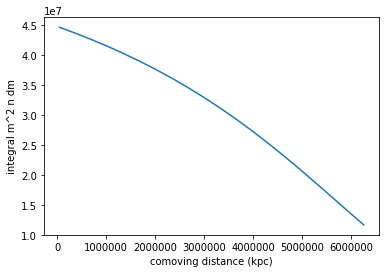

In [35]:
plt.plot(chi_list, mass_integral_list)
plt.xlabel('comoving distance (kpc)')
plt.ylabel('integral m^2 n dm')

In [38]:
mass_integral_func = interp1d(chi_list, mass_integral_list)

In [39]:
def integrand(chi, chil, chis):
    # kpc_comoving
    rad_term = double_cone_direct(chi, chil, chis)**2 / 1 # denom is automatically one in our convention
    return rad_term * mass_integral_func(chi)

def interloper_power(z_l, z_s):
    assert(z_l < z_s)
    sigcr = sigma_cr(z_l, z_s).to(u.Msun/u.kpc**2).value
    res = quad(integrand, z_to_chi(0.01), z_to_chi(z_s), args=(z_to_chi(z_l), z_to_chi(z_s)))
    power = res[0]/sigcr**2
    return power # in kpc^2

In [79]:
%%time

# Calculate interloper power (plateau) grid
zllist = np.linspace(0,3,100)
zslist = np.linspace(0,3,100)
int_power_grid = np.zeros((len(zllist), len(zslist)))
for i_l, z_l in enumerate(zllist):
    for i_s, z_s in enumerate(zslist):
        if z_s <= z_l: continue
        
        int_power_grid[i_l, i_s] = interloper_power(z_l, z_s)

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.
/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


CPU times: user 4min 40s, sys: 920 ms, total: 4min 41s
Wall time: 4min 39s


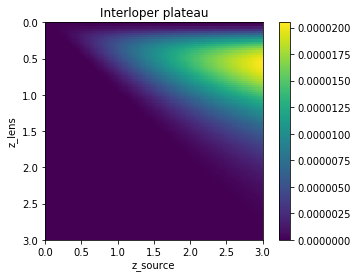

In [86]:
plt.imshow(int_power_grid, extent=[0,3,3,0])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Interloper plateau')
#plt.savefig('imgs/feb25_intplat.png')

In [88]:
interloper_power(.5, 1)

4.333003028903918e-06

In [81]:
interloper_power(.5, 3)

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


2.022979239025401e-05

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


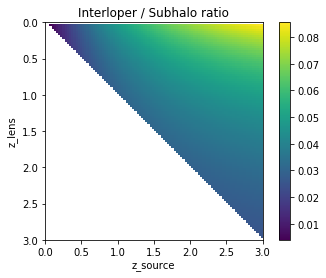

In [87]:
plt.imshow(int_power_grid / sub_power_grid, extent=[0,3,3,0])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Interloper / Subhalo ratio')
#plt.savefig('imgs/feb_25_int_sub_ratio.png')

## Putting $\Sigma_{cr}$ inside the integral

In [96]:
def integrand2(chi, chil, chis):
    # kpc_comoving
    rad_term = double_cone_direct(chi, chil, chis)**2 / 1 # denom is automatically one in our convention
    
    sigcr = sigma_cr(chi_to_z(chil), chi_to_z(chis)).to(u.Msun/u.kpc**2).value
    
    return rad_term * mass_integral_func(chi) / sigcr**2

def interloper_power2(z_l, z_s):
    assert(z_l < z_s)
    
    res = quad(integrand2, z_to_chi(0.01), z_to_chi(z_s), args=(z_to_chi(z_l), z_to_chi(z_s)))
    power = res[0]
    return power # in kpc^2

In [97]:
%%time
interloper_power2(.5,1)

CPU times: user 2.12 s, sys: 64 ms, total: 2.18 s
Wall time: 1.94 s


4.332968132105472e-06

In [ ]:
%%time

# Calculate interloper power (plateau) grid
zllist = np.linspace(.01,3,100)
zslist = np.linspace(.01,3,100)
int_power_grid2 = np.zeros((len(zllist), len(zslist)))
for i_l, z_l in enumerate(zllist):
    for i_s, z_s in enumerate(zslist):
        if z_s <= z_l: continue
        
        int_power_grid2[i_l, i_s] = interloper_power2(z_l, z_s)

In [ ]:
plt.imshow(int_power_grid2, extent=[0,3,3,0])
plt.xlabel('z_source')
plt.ylabel('z_lens')
plt.colorbar()
plt.title('Interloper plateau ($\\Sigma_{cr}$ inside integral)')
#plt.savefig('imgs/feb25_int2plat.png')

## Old cells

In [87]:
# # Load Press-Schechter results
# h = .675
# massesn = np.load('files/ps_results/massesn_wide.npy') # units solar masses
# massfunc_matrix = np.load('files/ps_results/massfunc_wide.npy') * h**3/1000**3 # convert Mpc/h^3 to 1/kpc^3
# zlist = np.load('files/ps_results/zs_wide.npy') # redshifts

# massfunc_ps = interp2d(zlist, massesn, massfunc_matrix, bounds_error=False) # function of (z, mass)